## Project 2 PARTIAL SENSING

Group Members:

1.   Dhiraj Bagul (netid: dvb30)
2.   Neil Pillai (netid: ncp67)
3. Shreyas Kulkarni (netid: spk111) 

In [ ]:
#importing libraries
import math as m
import numpy as np
import time as t

In [ ]:
def generate_grid_world(dim_x, dim_y, density):
    """
    Description: This function generates random grid_world of requested dimensions
    
    INPUT = dim_x (no. of rows), dim_y(no. of columns), 
            density(probability of cell being blocked) 

    OUTPUT = dim_x by dim_y dimensional grid_world filled with "O" and "X"
    where 'O' is cell that can be traversed and 'X' is cell which is blocked
    """
    mask = np.random.choice(["O", "X"], (dim_x, dim_y),
                            p=[1 - density, density])
    grid_world = mask.tolist()
    return grid_world

In [ ]:
"""
Heuristics functions
"""
def Euclidean_heuristics(x1, y1, x2, y2):
    estimated_distance = m.pow(x1 - x2, 2) + m.pow(y1 - y2, 2)
    return m.pow(estimated_distance, 0.5)


def Manhattan_heuristics(x1, y1, x2, y2):
    estimated_distance = (x1 - x2) + (y1 - y2)
    return abs(estimated_distance)


def Chebyshev_heuristics(x1, y1, x2, y2):
    estimated_distance = max(m.fabs(x1 - x2), m.fabs(y1 - y2))
    return estimated_distance

def combined_heuiristics(x1, y1, x2, y2):
    Euclidean = Euclidean_heuristics(x1,y1,x2,y2)
    Manhattan = Manhattan_heuristics(x1,y1,x2,y2)
    Chebyshev = Chebyshev_heuristics(x1,y1,x2,y2)

    combined_heuiristics = 2*Euclidean + 5*Manhattan + 3*Chebyshev
    return combined_heuiristics

In [ ]:
class cell:
    """
    This class is schema for explorable cells and stores information about them.
    Whenever we explore cell that we are currently in, we would first check if its
    childs are explorable or not. However, many childs that we can explore
    could contain a potential path towards our goal state, hence we would create
    its object and store that in the priority queue. If that cell is already
    present in the queue then we will check if current path is better than the
    previous one, and if we need to update corresponding f(n) and parent node.
    """

    def __init__(self, cell_index):
        """storing cell index for future references"""
        self.cell_index = cell_index
        #self.key = str(cell_index[0] + cell_index[1])

    def set_hon(self, goal_index, heuristics_to_use):
        """
        Based on the heuristics chosen finding out h(n) for the current cell.
        """
        if heuristics_to_use == "M":
            self.hon = Manhattan_heuristics(
                self.cell_index[0], self.cell_index[1], goal_index[0], goal_index[1])
        elif heuristics_to_use == "E":
            self.hon = Euclidean_heuristics(
                self.cell_index[0], self.cell_index[1], goal_index[0], goal_index[1])
        elif heuristics_to_use == "C":
            self.hon = Chebyshev_heuristics(
                self.cell_index[0], self.cell_index[1], goal_index[0], goal_index[1])
        elif heuristics_to_use == "CO":
            self.hon = combined_heuiristics(
                self.cell_index[0], self.cell_index[1], goal_index[0], goal_index[1])

    def set_gon(self, parent_gon):  
        """
        calculating the g(n) for current cell based on the g(n) of parent.
        Considering each step takes 1 unit of energy to traverse then,
                        g(n) = g(parent(n)) + 1
        """
        self.gon = parent_gon + 1

    def set_fon(self):
        """
        Estimated total cost from current cell, n, to reach the goal f(n) is
        given by f(n) = g(n) + h(n)
        """
        self.fon = self.hon + self.gon
        return self.fon

    def set_parent_index(self, parent_index):
        self.parent = parent_index

    def compare_new_old_path(self, gon_new_parent, new_parent_index):
      """
      In case we find a new path to a cell while pathplanning, we need to comapre
      it to the old parent and see whether new path is more optimal and hence update
      its parent and path accordingly.
      """
      if self.fon > self.hon + gon_new_parent + 1:
          self.gon = gon_new_parent + 1
          self.fon = self.gon + self.hon
          self.set_parent_index(new_parent_index)

In [ ]:
class PriorityQueue:
    """
    This class will be schema for maintaining the priority queue/open list that we 
    need to use for our unexplored potential paths that can lead to goal state. 
    We will use f(n) to prioritize next node that we need to take out and explore.
    """

    def __init__(self, goal_index):
        self.queue = {}
        self.explored_cells = {}  # Closed list required to store already visited cells
        self.goal_index = goal_index

    def check_if_in_queue(self, cell_key):
        if cell_key in self.queue:
            return True
        return False

    def add_cell(self, cell_key, object):
        self.queue[cell_key] = object

    def get_next_cell(self):
        # compare based on fon. Remove and return the cell with smallest fon
        min_fon = 9999999
        next_cell_to_explore = []

        start_time = time.time()
        for cell_key in self.queue:
            current_cell = self.queue[cell_key]
            current_cell_fon = current_cell.fon
            current_cell_index = current_cell.cell_index
            if current_cell_fon < min_fon:
                min_fon = current_cell_fon
                next_cell_to_explore = current_cell_index
                next_cell_key = cell_key
        self.explored_cells[next_cell_key] = self.queue.pop(next_cell_key)
        #print("--- %s seconds ---" % (time.time() - start_time))
        return next_cell_to_explore

In [ ]:
def add_or_update_child(PriQueue, child, parent, heuristics_to_use):
    cell_key_child = str(child[0]) + str(child[1])
    cell_key_parent = str(parent[0]) + str(parent[1])

    # If cell already in PriorityQueue, check if current path is better
    if PriQueue.check_if_in_queue(cell_key_child):
        gon_parent = PriQueue.explored_cells[cell_key_parent].gon
        new_parent_index = PriQueue.explored_cells[cell_key_parent].cell_index
        PriQueue.queue[cell_key_child].compare_new_old_path(
            gon_parent, new_parent_index)

    # If cell already in explored cells, check if current path is better
    elif cell_key_child in PriQueue.explored_cells:
        gon_parent = PriQueue.explored_cells[cell_key_parent].gon
        new_parent_index = PriQueue.explored_cells[cell_key_parent].cell_index
        PriQueue.explored_cells[cell_key_child].compare_new_old_path(
            gon_parent, new_parent_index)

    # if not in PriQueue or in Explored cells, create new cell and add it in PriQueue
    else:
        PriQueue.add_cell(cell_key_child, cell(child))
        gon_parent = PriQueue.explored_cells[cell_key_parent].gon
        PriQueue.queue[cell_key_child].set_hon(
            PriQueue.goal_index, heuristics_to_use)
        PriQueue.queue[cell_key_child].set_gon(gon_parent)
        PriQueue.queue[cell_key_child].set_fon()
        PriQueue.queue[cell_key_child].set_parent_index(parent)

    return PriQueue

In [ ]:
def can_explore(grid_world, child):
    if grid_world[child[0]][child[1]] != "X" and grid_world[child[0]][child[1]] != "S":
        return True
    return False


def is_valid_position(position, max_dim):
    if position >= 0 and position <= max_dim:
        return True
    return False


def find_childs(PriQueue, current_knoweldge_grid, current_pos, heuristics_to_use):
    x_pos = current_pos[0]
    y_pos = current_pos[1]

    max_x = PriQueue.goal_index[0]
    max_y = PriQueue.goal_index[1]
    
    if is_valid_position(x_pos - 1, max_x):
        child_left = [x_pos - 1, y_pos]
        if can_explore(current_knoweldge_grid, child_left):
            PriQueue = add_or_update_child(PriQueue, child_left,
                                current_pos, heuristics_to_use)

    if is_valid_position(x_pos + 1, max_x):
        child_right = [x_pos + 1, y_pos]
        if can_explore(current_knoweldge_grid, child_right):
            PriQueue = add_or_update_child(PriQueue, child_right,
                                current_pos, heuristics_to_use)

    if is_valid_position(y_pos - 1, max_y):
        child_up = [x_pos, y_pos - 1]
        if can_explore(current_knoweldge_grid, child_up):
            PriQueue = add_or_update_child(PriQueue, child_up,
                                current_pos, heuristics_to_use)

    if is_valid_position(y_pos + 1, max_y):
        child_down = [x_pos, y_pos + 1]
        if can_explore(current_knoweldge_grid, child_down):
            PriQueue = add_or_update_child(PriQueue, child_down,
                                current_pos, heuristics_to_use)
    return PriQueue


In [ ]:
def get_path(PriQueue, goal_cell):
    path = list()
    path.insert(0, goal_cell)
    cell = goal_cell
    while cell.parent != None:
        parent_cell_key = str(cell.parent[0]) + str(cell.parent[1])
        #print(parent_cell_key)
        cell = PriQueue.explored_cells[parent_cell_key]
        path.insert(0, cell)
    return path


def plan_path(current_knoweldge_grid, heuristics_to_use, start_position, goal_position):
    """
    In this part we would perform pathfinding with the help of the A star algo.
    Based on the current_knowledge, we will try to find optimal solution to reach
    from one position to the end goal. The start point initially will be the
    start position but while applying repitative A star we would move along some
    path until we hit a block and hence the start position will keep on changing.
    """
    PriQueue = PriorityQueue(goal_position)

    start_cell_key = str(start_position[0]) + str(start_position[1])
    start_cell = cell(start_position)
    start_cell.parent = None
    start_cell.set_gon(0)
    start_cell.set_hon(goal_position, heuristics_to_use)
    start_cell.set_fon()

    PriQueue.add_cell(start_cell_key, start_cell)

    while PriQueue.queue:
        next_cell_to_explore = PriQueue.get_next_cell()
        #print(next_cell_to_explore)
        if next_cell_to_explore != None:
            if current_knoweldge_grid[next_cell_to_explore[0]][next_cell_to_explore[1]] == "G":
                current_cell_key = str(next_cell_to_explore[0]) + str(next_cell_to_explore[1])
                path = get_path(PriQueue, PriQueue.explored_cells[current_cell_key])
                return path
            else:
                PriQueue = find_childs(PriQueue, current_knoweldge_grid,
                            next_cell_to_explore, heuristics_to_use)
        else:
            return None

In [ ]:
def update_current_knowledge_grid(current_knoweldge_grid, grid_world, current_position):
    """
    The path that we found has a block in it, so we can not go further, hence
    we will update our knowledge space and replan to find path to the goal state.
    """
    x_pos = current_position[0]
    y_pos = current_position[1]

    if is_valid_position(x_pos - 1, 100):
        current_knoweldge_grid[x_pos - 1][y_pos] = grid_world[x_pos - 1][y_pos]

    if is_valid_position(x_pos + 1, 100):
        current_knoweldge_grid[x_pos + 1][y_pos] = grid_world[x_pos + 1][y_pos]

    if is_valid_position(y_pos - 1, 100):
        current_knoweldge_grid[x_pos][y_pos - 1] = grid_world[x_pos][y_pos - 1]

    if is_valid_position(y_pos + 1, 100):
        current_knoweldge_grid[x_pos][y_pos + 1] = grid_world[x_pos][y_pos + 1]

    return current_knoweldge_grid


def traverse_current_path(current_path, grid_world, current_knoweldge_grid):
    """
    For the current path discovered, traverse and update knowledge by observing
    cells that are nearby until the agent runs into a cell that is blocked or is 
    goal state.
    """
    traversable_path = list()
    for cell in current_path:
        position_x = cell.cell_index[0]
        position_y = cell.cell_index[1]
        if grid_world[position_x][position_y] == "X":
            current_knoweldge_grid[position_x][position_y] = "X"
            return cell, current_knoweldge_grid, traversable_path
        traversable_path.append(cell)
        current_position = [position_x, position_y]
        current_knowledge_grid = update_current_knowledge_grid(current_knoweldge_grid, grid_world, current_position)
    return cell, current_knoweldge_grid, traversable_path

def traverse_current_path_limited_fov(current_path, grid_world, current_knoweldge_grid):
    """
    For the current path discovered, traverse and update knowledge by observing
    cells that are nearby until the agent runs into a cell that is blocked or is 
    goal state.
    """
    traversable_path = list()
    for cell in current_path:
        position_x = cell.cell_index[0]
        position_y = cell.cell_index[1]
        if grid_world[position_x][position_y] == "X":
            current_knoweldge_grid[position_x][position_y] = "X"
            return cell, current_knoweldge_grid, traversable_path
        traversable_path.append(cell)
        current_position = [position_x, position_y]
    return cell, current_knoweldge_grid, traversable_path


def repeated_a_star(grid_world, current_knoweldge_grid, start_position, goal_position, heuristics_to_use):
    """
    We will use the repitative a_star with our current knowledge of the grid_world
    to find an optimal path, we will traverse that path until we bump into a blocked
    cell. Then, from that point we will update our knowledge and replan to find
    the solution.
    """
    total_cell_processed = 0
    total_path = []
    while True:
        path = plan_path(current_knoweldge_grid,
                         heuristics_to_use, start_position, goal_position)
        #path_index = [i.cell_index for i in path]
        #print(path)
        if path == None:
            return "No Path exists"

        # Travel current path and see until which point can the robot go without
        # hitting the blocked
        else:
            total_cell_processed = total_cell_processed + len(path) 
            current_position, current_knoweldge_grid, current_path = traverse_current_path(path, grid_world, current_knoweldge_grid)
            current_position_index = current_position.cell_index
            total_path = total_path + current_path 
            if current_position_index[0] == goal_position[0] and current_position_index[1] == goal_position[1]:
                return len(total_path), total_cell_processed, current_knoweldge_grid
            else:
                start_position = current_position.parent



In [ ]:
import time

dim_x, dim_y, density = 101, 101, 0.2

grid_world = generate_grid_world(dim_x, dim_y, density)

# current_knoweldge_grid = list(grid_world)
# current_knoweldge_grid = [['O' for j in range(0, dim_x)] for i in range(0, dim_y)]
# current_knoweldge_grid = [[['O', 0, 0, 0, 0, 0] for j in range(0, dim_x)] for i in range(0, dim_y)]
current_knoweldge_grid = generate_grid_world(dim_x, dim_y, 0)

start_position = [0, 0]
goal_position = [dim_x - 1, dim_y - 1]

grid_world[start_position[0]][start_position[1]] = "O"
grid_world[goal_position[0]][goal_position[1]] = "G"
current_knoweldge_grid[goal_position[0]][goal_position[1]] = "G"


In [ ]:
print(current_knoweldge_grid)

[[['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0,

In [ ]:
data = repeated_a_star(grid_world, current_knoweldge_grid, start_position, goal_position, "M")

In [ ]:
print(data)

(304, 5815, [['O', 'X', ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0, 0, 0, 0, 0], ['O', 0,

Question 4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

dim_x=101
dim_y=101

p_value_list = []
total_solvable_grid_list = []

p_value = 0
increment = 0.05

while p_value <= 0.5:
    density = p_value
    solvable_grids = 0
    for i in range(0, 100):
        grid_world = generate_grid_world(dim_x, dim_y, density)
        current_knoweldge_grid = list(grid_world)
        start_position = [0, 0]
        goal_position = [dim_x - 1, dim_y - 1]
        grid_world[start_position[0]][start_position[1]] = "O"
        grid_world[goal_position[0]][goal_position[1]] = "G"
        current_knoweldge_grid[goal_position[0]][goal_position[1]] = "G"
        data = repeated_a_star(grid_world, current_knoweldge_grid, start_position, goal_position, "M")
        if data != "No Path exists":
            solvable_grids = solvable_grids + 1
    p_value = p_value + increment
    p_value_list.append(density)
    total_solvable_grid_list.append(solvable_grids)

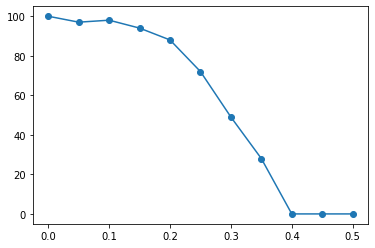

In [ ]:
plt.plot(p_value_list, total_solvable_grid_list,'-o')

plt.show()

Question 5

In [ ]:
dim_x = 101                 # total number of rows of the grid_world
dim_y = 101                 # total number of columns of the grid_world
density = 0.2               # Probability of a cell being blocked

p_value_list = []
manhattan_list = []
euclidean_list = []
chebyshev_list = []
p_value = 0.4
increment = 0.15
while p_value <= 0.6:
    density = p_value
    total_solved = 0
    time_manhattan = time.time() - time.time()
    time_euclidean = time.time() - time.time()
    time_chebyshev = time.time() - time.time()
    for i in range(0, 50):
        grid_world = generate_grid_world(dim_x, dim_y, density)
        current_knoweldge_grid = list(grid_world)
        start_position = [0, 0]
        goal_position = [dim_x - 1, dim_y - 1]
        grid_world[start_position[0]][start_position[1]] = "O"
        grid_world[goal_position[0]][goal_position[1]] = "G"
        current_knoweldge_grid[goal_position[0]][goal_position[1]] = "G"
        
        # Manhattan
        start_time = time.time()
        data = repeated_a_star(grid_world, current_knoweldge_grid, start_position, goal_position, "M")
        end_time = time.time()

        #if data != "No Path exists":
        total_solved = total_solved + 1
        time_manhattan = time_manhattan + end_time - start_time
        
        # Euclidean
        start_time = time.time()
        data = repeated_a_star(grid_world, current_knoweldge_grid, start_position, goal_position, "E")
        end_time = time.time()

        #if data != "No Path exists":
        time_euclidean = time_euclidean + end_time - start_time
        
        # Chebyshev
        start_time = time.time()
        data = repeated_a_star(grid_world, current_knoweldge_grid, start_position, goal_position, "C")
        end_time = time.time()

        #if data != "No Path exists":
        time_chebyshev = time_chebyshev + end_time - start_time
    
    p_value_list.append(density)
    
    time_manhattan /= total_solved
    time_euclidean /= total_solved
    time_chebyshev /= total_solved

    manhattan_list.append(time_manhattan)
    euclidean_list.append(time_euclidean)
    chebyshev_list.append(time_chebyshev)

    p_value += increment

In [ ]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

a = ['Probability = 0.0',0.354960,0.401454,0.387973]
b = ['Probability = 0.15',0.254883,0.286096,0.294496]
c = ['Probability = 0.30',0.127699,0.168260,0.189967]
d = ['Probability = 0.45',0.017040,0.017407,0.018514]
e = ['Probability = 0.60',0.000077,0.000071,0.000077]

df = pd.DataFrame([['','Manhattan','Chebyshev','Euclidean'],a,b,c,d,e])
df

Question 6

In [ ]:
dim_x = 101                 # total number of rows of the grid_world
dim_y = 101                 # total number of columns of the grid_world

import time
density = 0.0
avg_trajectory_length_list = []
avg_trajectory_length_by_shortest_path_list = []
avg_trajectory_pdg_by_fwg_list = []
avg_processed_cells = []

while(density <= 0.33):
    repeated_a_star_path_trajectory = 0
    repeated_a_star_cell_processed = 0
    partially_a_star_path_trajectory = 0
    partially_a_star_cell_processed = 0
    full_a_star_path_trajectory = 0
    full_a_star_cell_processed = 0
    solved_grids = 0

    for i in range(0, 10):
        
        grid_world = generate_grid_world(dim_x, dim_y, density)
        current_knoweldge_grid = generate_grid_world(dim_x, dim_y, 0)
        start_position = [0, 0]
        goal_position = [dim_x - 1, dim_y - 1]

        grid_world[start_position[0]][start_position[1]] = "O"
        grid_world[goal_position[0]][goal_position[1]] = "G"
        current_knoweldge_grid[goal_position[0]][goal_position[1]] = "G"
        
        data = repeated_a_star(grid_world, current_knoweldge_grid,
                            start_position, goal_position, "M")

        if data != "No Path exists":
            solved_grids += 1
            repeated_a_star_path_trajectory += data[0]
            repeated_a_star_cell_processed += data[1]
            current_knoweldge_grid = data[2]
            #print(data)
            
            # Partially discovered grid world from start
            data = repeated_a_star(grid_world, current_knoweldge_grid,
                            start_position, goal_position, "M")
            
            partially_a_star_path_trajectory += data[0]
            partially_a_star_cell_processed = data[1]
            #print(data)

            # Full gridworld
            data = repeated_a_star(grid_world, grid_world,
                        start_position, goal_position, "M")
            full_a_star_path_trajectory += data[0]
            full_a_star_cell_processed += data[1]
            #print(data)
        

    avg_trajectory_length_list.append(int(repeated_a_star_path_trajectory/solved_grids))
    avg_trajectory_length_by_shortest_path_list.append(repeated_a_star_path_trajectory/partially_a_star_path_trajectory)
    avg_trajectory_pdg_by_fwg_list.append(partially_a_star_path_trajectory/full_a_star_path_trajectory)
    avg_processed_cells.append(repeated_a_star_cell_processed/solved_grids)

    density += 0.05

In [ ]:
# Plot 1: Density vs Avergae Trajectory Length
p_value = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
x = p_value
y = avg_trajectory_length_list

avg_trajectory_length_dict = {'p_value':p_value, 'Average':y}
dF = pd.DataFrame(avg_trajectory_length_dict)

plt.plot(p_value, y,'-o')
plt.xlabel('p_value')
plt.ylabel('Average')
plt.show()

dF

In [ ]:
# Plot 2: Density vs Avergae (Trajectory Length/ shortest path in final grid)

x = p_value
y = avg_trajectory_length_by_shortest_path_list

avg_trajectory_length_by_shortest_path_dict = {'p_value':x, 'Average':y}
dF = pd.DataFrame(avg_trajectory_length_by_shortest_path_dict)

plt.plot(x, y,'-o')
plt.xlabel('p_value')
plt.ylabel('Average')
plt.show()

print(dF)

In [ ]:
# Plot 3: Density vs Avergae (Shortest path in final/ shortest path in full grid)

x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
y = avg_trajectory_pdg_by_fwg_list

avg_trajectory_pdg_by_fwg_dict = {'p_value':x, 'Average':y}
dF = pd.DataFrame(avg_trajectory_pdg_by_fwg_dict)

plt.plot(x, y,'-o')
plt.xlabel('p_value')
plt.ylabel('Average')
plt.show()

print(dF)

In [ ]:
# Plot 4: Number of cells processed by repeated A*
x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
y = avg_processed_cells

avg_processed_cells_dict = {'p_value':x, 'Average':y}
dF = pd.DataFrame(avg_processed_cells_dict)

plt.plot(x, y,'-o')
plt.xlabel('p_value')
plt.ylabel('Average')
plt.show()

print(dF)

Question 7 

In [ ]:
def repeated_a_star_limited_fov(grid_world, current_knoweldge_grid, start_position, goal_position, heuristics_to_use):
    """
    We will use the repitative a_star with our current knowledge of the grid_world
    to find an optimal path, we will traverse that path until we bump into a blocked
    cell. Then, from that point we will update our knowledge and replan to find
    the solution.
    """
    total_cell_processed = 0
    total_path = []
    while True:
        path = plan_path(current_knoweldge_grid,
                         heuristics_to_use, start_position, goal_position)
        #path_index = [i.cell_index for i in path]
        #print(path)
        if path == None:
            return "No Path exists"

        # Travel current path and see until which point can the robot go without
        # hitting the blocked
        else:
            total_cell_processed = total_cell_processed + len(path) 
            current_position, current_knoweldge_grid, current_path = traverse_current_path_limited_fov(path, grid_world, current_knoweldge_grid)
            current_position_index = current_position.cell_index
            total_path = total_path + current_path 
            if current_position_index[0] == goal_position[0] and current_position_index[1] == goal_position[1]:
                return len(total_path), total_cell_processed, current_knoweldge_grid
            else:
                start_position = current_position.parent


dim_x = 101                 # total number of rows of the grid_world
dim_y = 101                 # total number of columns of the grid_world

import time
density = 0.0
avg_trajectory_length_list = []
avg_trajectory_length_by_shortest_path_list = []
avg_trajectory_pdg_by_fwg_list = []
avg_processed_cells = []

while(density <= 0.33):
    repeated_a_star_path_trajectory = 0
    repeated_a_star_cell_processed = 0
    partially_a_star_path_trajectory = 0
    partially_a_star_cell_processed = 0
    full_a_star_path_trajectory = 0
    full_a_star_cell_processed = 0
    solved_grids = 0

    for i in range(0, 10):
        
        grid_world = generate_grid_world(dim_x, dim_y, density)
        current_knoweldge_grid = generate_grid_world(dim_x, dim_y, 0)
        start_position = [0, 0]
        goal_position = [dim_x - 1, dim_y - 1]

        grid_world[start_position[0]][start_position[1]] = "O"
        grid_world[goal_position[0]][goal_position[1]] = "G"
        current_knoweldge_grid[goal_position[0]][goal_position[1]] = "G"
        
        data = repeated_a_star_limited_fov(grid_world, current_knoweldge_grid,
                            start_position, goal_position, "M")

        if data != "No Path exists":
            solved_grids += 1
            repeated_a_star_path_trajectory += data[0]
            repeated_a_star_cell_processed += data[1]
            current_knoweldge_grid = data[2]
            #print(data)
            
            # Partially discovered grid world from start
            data = repeated_a_star_limited_fov(grid_world, current_knoweldge_grid,
                            start_position, goal_position, "M")
            
            partially_a_star_path_trajectory += data[0]
            partially_a_star_cell_processed = data[1]
            #print(data)

            # Full gridworld
            data = repeated_a_star_limited_fov(grid_world, grid_world,
                        start_position, goal_position, "M")
            full_a_star_path_trajectory += data[0]
            full_a_star_cell_processed += data[1]
            #print(data)
        

    avg_trajectory_length_list.append(int(repeated_a_star_path_trajectory/solved_grids))
    avg_trajectory_length_by_shortest_path_list.append(repeated_a_star_path_trajectory/partially_a_star_path_trajectory)
    avg_trajectory_pdg_by_fwg_list.append(partially_a_star_path_trajectory/full_a_star_path_trajectory)
    avg_processed_cells.append(repeated_a_star_cell_processed/solved_grids)

    density += 0.05

In [ ]:

x = p_value
y = avg_trajectory_length_list

avg_trajectory_length_dict = {'p_value':x, 'Average':y}
dF = pd.DataFrame(avg_trajectory_length_dict)

plt.plot(x, y,'-o')
plt.xlabel('p_value')
plt.ylabel('Average')
plt.show()

print(dF)

In [ ]:
x = p_value
y = avg_trajectory_length_by_shortest_path_list

avg_trajectory_length_by_shortest_path_dict = {'p_value':x, 'Average':y}
dF = pd.DataFrame(avg_trajectory_length_by_shortest_path_dict)

plt.plot(x, y,'-o')
plt.xlabel('p_value')
plt.ylabel('Average')
plt.show()

print(dF)

In [ ]:
x = p_value
y = avg_trajectory_pdg_by_fwg_list

avg_trajectory_pdg_by_fwg_dict = {'p_value':x, 'Average':y}
dF = pd.DataFrame(avg_trajectory_pdg_by_fwg_dict)

plt.plot(x, y,'-o')
plt.xlabel('p_value')
plt.ylabel('Average')
plt.show()

print(dF)

In [ ]:
x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
y = avg_processed_cells_list

avg_processed_cells_dict = {'p_value':x, 'Average':y}
dF = pd.DataFrame(avg_processed_cells_dict)

plt.plot(x, y,'-o')
plt.xlabel('p_value')
plt.ylabel('Average')
plt.show()

print(dF)

In [ ]:
# Plot 1: Density vs Runtime for Manhattan and Weigted

list1 = {'p_value':Density_Value, 'Average':Time_Weighted}
list2 = {'p_value':Density_Value, 'Average':Time_Manhattan}

dF = pd.DataFrame(list1)
dF = pd.DataFrame(list2)

plt.plot(Density_Value, Time_Weighted,color = 'red', label='Weighted')
plt.plot(Density_Value, Time_Manhattan,color ='blue', label='Manhattan')
plt.legend()
plt.xlabel('Density')
plt.ylabel('Weighted and Manhattan time')
plt.show()

print(dF)

In [ ]:
# Plot 1: Density vs Path length for Manhattan and Weigted

list1 = {'p_value':Density_Value, 'Average':Path_length_weighted}
list2 = {'p_value':Density_Value, 'Average':Path_length_manhattan}

dF = pd.DataFrame(list1)
dF = pd.DataFrame(list2)

plt.plot(Density_Value, Path_length_weighted,color='red', label='Weighted')
plt.plot(Density_Value, Path_length_manhattan,color='blue', label= 'Manhattan')
plt.legend()
plt.xlabel('Density')
plt.ylabel('Weighted and Manhattan path')
plt.show()

print(dF)

In [ ]:
# Plot 3: P_Value vs Path_length_weighted
list1 = {'p_value':Time_Weighted, 'Average':Path_length_weighted}
dF = pd.DataFrame(list1)

plt.plot(Time_Weighted, Path_length_weighted,'-o')
plt.xlabel('Time')
plt.ylabel('Weighted path')
plt.show()

print(dF)